In [1]:
# TODO: use cross-validation to get a better estimate of the model performance

# NOTE: bath normalization and residual connection are especially important for deep networks

# TODO: save the best model and load it again to make predictions on the test data

# TODO: do I only need to normalize the test data? 
#       Or only take the mean and std of the training data and apply it to all data?

# TODO: add hyperparameter tuning

# TODO: maybe data augmentation helps to improve the model performance

In [2]:
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

In [3]:
# read in the excel-file with the labels
label_path = "X:/MasterThesis_Reto"
label_file = "Conn_IDs_Matching.xlsx"
# read excel with only the first three columns
label_df = (pd.read_excel(os.path.join(label_path, label_file),
                            usecols=[0, 1, 2])
            .replace({"Cond": {1: 0}})
            .replace({"Cond": {2: 1}})
            )

label_df[-5:]

,Conn_SubjNr,VPNr,Cond
63,64,80,0
64,65,83,0
65,66,86,1
66,67,87,1
67,68,88,0


In [4]:
# read MVPA data
file_path = "X:/MasterThesis_Reto/Denoised_Data_6mm"
path_content = os.listdir(os.path.join(file_path, "MVPA_data"))

# make two lists with pre (Condition002) and post (Condition003) data of first component
comp1_pre = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition002" in x])
comp1_post = sorted([x for x in path_content 
                    if "Component001" in x 
                    and "Condition003" in x])

print(comp1_pre[:5])

['BETA_Subject001_Condition002_Measure002_Component001.nii', 'BETA_Subject002_Condition002_Measure002_Component001.nii', 'BETA_Subject003_Condition002_Measure002_Component001.nii', 'BETA_Subject004_Condition002_Measure002_Component001.nii', 'BETA_Subject005_Condition002_Measure002_Component001.nii']


In [5]:
# create a dataset with the difference of pre and post data
comp1_diff = []
for pre, post in zip(comp1_pre, comp1_post):
    pre_vol = nib.load(os.path.join(file_path, "MVPA_data", pre))
    post_vol = nib.load(os.path.join(file_path, "MVPA_data", post))
    pre_vol_data = pre_vol.get_fdata()
    post_vol_data = post_vol.get_fdata()
    diff_vol_data = post_vol_data - pre_vol_data
    comp1_diff.append(diff_vol_data)

# check the shape of the data
print(comp1_diff[0].shape)

# check the type of the data
print(type(comp1_diff[0]))

# takes about 4 mins to run on Dell

(91, 109, 91)
<class 'numpy.ndarray'>


In [6]:
# stack the data to later use it as input for the CNN
# note: the first dimension is the number of samples
print(f"shape of one list element before stacking: {comp1_diff[0].shape=}")
inpt_comp1_diff = np.stack(comp1_diff, axis=0)

# expand the dimensions to fit the input shape of the CNN
# note: the last dimension is the number of channels
inpt_comp1_diff = np.expand_dims(inpt_comp1_diff, axis=-1)

# normalize the input data (zero mean, unit variance)
# note: a CNN works best with normalized data
inpt_comp1_diff = (inpt_comp1_diff - inpt_comp1_diff.mean()) / inpt_comp1_diff.std()

print(f"{inpt_comp1_diff.shape=}",
      f"{inpt_comp1_diff.mean()=}",
      f"{inpt_comp1_diff.std()=}", sep="\n")

shape of one list element before stacking: comp1_diff[0].shape=(91, 109, 91)
inpt_comp1_diff.shape=(68, 91, 109, 91, 1)
inpt_comp1_diff.mean()=1.2019033790773762e-16
inpt_comp1_diff.std()=0.9999999999999889


In [7]:
# split the data into training and test data
# use 80% of the data for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(inpt_comp1_diff, 
                                                    label_df["Cond"], 
                                                    test_size=0.2,
                                                    random_state=42)

# check the shape of the data
print(f"{x_train.shape=}",
        f"{x_test.shape=}",
        f"{y_train.shape=}",
        f"{y_test.shape=}", sep="\n")

# prepare for k-fold cross-validation
# note: StratifiedKFold ensures that the proportion of samples of each class is the same in each fold
nbr_of_folds = 12
kfold = StratifiedKFold(n_splits=nbr_of_folds, shuffle=True, random_state=42)

x_train.shape=(54, 91, 109, 91, 1)
x_test.shape=(14, 91, 109, 91, 1)
y_train.shape=(54,)
y_test.shape=(14,)


In [8]:
# built a keras CNN model with functional API
def build_and_compile_model(summary=False):
    inputs = keras.Input(shape=(inpt_comp1_diff.shape[1:]))
    x = layers.Conv3D(filters=16, kernel_size=3, 
                        kernel_regularizer=regularizers.l2(0.002),
                        activation="relu") (inputs)
    x = layers.MaxPooling3D(pool_size=3, 
                            strides=3, 
                            padding='valid') (x)
    x = layers.Conv3D(filters=32, kernel_size=3, 
                        kernel_regularizer=regularizers.l2(0.002), 
                        activation="relu") (x)
    # x = layers.MaxPooling3D(pool_size=3, 
    #                         strides=3, 
    #                         padding='valid')(x)
    # x = layers.Conv3D(filters=32, kernel_size=3, 
    #                     kernel_regularizer=regularizers.l2(0.002), 
    #                     activation="relu")(x)
    x = layers.Flatten() (x)
    x = layers.Dense(128, activation="relu",
                        kernel_regularizer=regularizers.l2(0.002)) (x)
    x = layers.Dense(64, activation="relu",
                        kernel_regularizer=regularizers.l2(0.002)) (x)
    outputs = layers.Dense(1, activation="sigmoid") (x)

    # define the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    if summary == True:
        model.summary()

    # compile the model
    my_optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
    model.compile(optimizer=my_optimizer,
                    loss='binary_crossentropy',
                    metrics=["Accuracy"])

    return model

In [9]:
# callback to stop training when loss does not improve anymore and save the best model
callback_list = [callbacks.EarlyStopping(monitor="val_loss", patience=5),
                 callbacks.ModelCheckpoint(filepath="./MVPA_CNN_model_cv.keras", 
                                            monitor="val_loss",
                                            save_best_only=True)]

# create empty lists to store the results of the k-fold cross-validation
val_loss = []
val_acc = []
history_list = []

# k-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train, y_train)):
    if fold == 0:
        print(f"cross validation started...", 
                f"size of the training data: {len(train_idx)}",
                f"size of the test data: {len(test_idx)}", 
                sep="\n")

    # create the folds
    print(f"Fold {fold+1} of {nbr_of_folds}")
    x_train_fold = x_train[train_idx]
    x_test_fold = x_train[test_idx]
    y_train_fold = y_train.iloc[train_idx]
    y_test_fold = y_train.iloc[test_idx]

    # print shape of the folds
    # print(f"{x_train_fold.shape=}",
    #     f"{x_test_fold.shape=}",
    #     f"{y_train_fold.shape=}",
    #     f"{y_test_fold.shape=}", sep="\n")

    # build and compile the model
    model = build_and_compile_model()

    # train the model
    history = model.fit(x_train_fold, y_train_fold,
                        epochs=20,
                        batch_size=4,
                        validation_data=(x_test_fold, y_test_fold),
                        callbacks=callback_list,
                        verbose=1)
    history_list.append(history)
    
    # load the best model
    model = keras.models.load_model("./MVPA_CNN_model_cv.keras")

    # evaluate the model
    fold_loss = model.evaluate(x_test_fold, y_test_fold, verbose=0)[0]
    fold_acc = model.evaluate(x_test_fold, y_test_fold, verbose=0)[1]
    val_loss.append(fold_loss)
    val_acc.append(fold_acc)
    print(f"Loss: {fold_loss}", f"Accuracy: {fold_acc}", sep="\n")

# print the mean of the validation loss and accuracy
print(f"Mean validation loss: {np.mean(val_loss)}",
        f"Mean validation accuracy: {np.mean(val_acc)}", sep="\n")
# save the model
# model.save("X:/MasterThesis_Reto/3d_cnn_model")

cross validation started...
size of the training data: 49
size of the test data: 5
Fold 1 of 12
Epoch 1/20
13/13 [==============================] - 25s 2s/step - loss: 8.6641 - Accuracy: 0.4898 - val_loss: 5.2784 - val_Accuracy: 0.4000
Epoch 2/20
13/13 [==============================] - 19s 1s/step - loss: 2.0582 - Accuracy: 0.6531 - val_loss: 1.7039 - val_Accuracy: 0.4000
Epoch 3/20
13/13 [==============================] - 17s 1s/step - loss: 1.0516 - Accuracy: 0.7551 - val_loss: 4.1008 - val_Accuracy: 0.6000
Epoch 4/20
13/13 [==============================] - 19s 1s/step - loss: 1.1624 - Accuracy: 0.7143 - val_loss: 5.7974 - val_Accuracy: 0.4000
Epoch 5/20
13/13 [==============================] - 18s 1s/step - loss: 0.5590 - Accuracy: 0.8980 - val_loss: 1.7908 - val_Accuracy: 0.6000
Epoch 6/20
13/13 [==============================] - 20s 2s/step - loss: 0.7565 - Accuracy: 0.8980 - val_loss: 1.0404 - val_Accuracy: 0.6000
Epoch 7/20
13/13 [==============================] - 19s 1s/step 

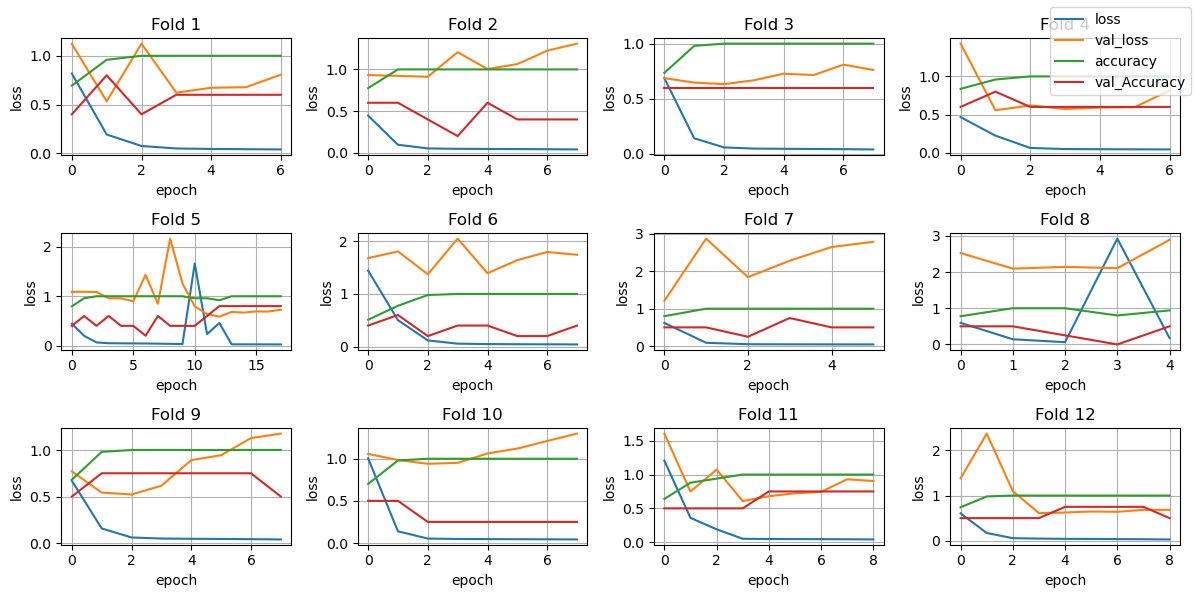

In [ ]:
# create subplot to show all folds
fig, axs = plt.subplots(3, 4, figsize=(12, 6))
axs = axs.ravel()
for i, history in enumerate(history_list):
    axs[i].plot(history.history["loss"][1:])
    axs[i].plot(history.history["val_loss"][1:])
    axs[i].plot(history.history["Accuracy"][1:])
    axs[i].plot(history.history["val_Accuracy"][1:])
    axs[i].set_title(f"Fold {i+1}")
    axs[i].set_ylabel("loss")
    axs[i].set_xlabel("epoch")
    axs[i].grid()

fig.tight_layout()
fig.legend(["loss", "val_loss", "accuracy", "val_Accuracy"])


In [ ]:

# plot the training history
fig = plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["Accuracy"])
plt.plot(history.history["val_Accuracy"])
plt.title("training history")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "val_loss", "accuracy", "val_Accuracy"], loc="upper left")
plt.grid()
plt.show()

In [134]:
# train with entire training data (no validation data)
# callback to stop training when loss does not improve anymore and save the best model
callback_list = [callbacks.EarlyStopping(monitor="loss", patience=5),
                 callbacks.ModelCheckpoint(filepath="./MVPA_CNN_model.keras", 
                                            monitor="loss",
                                            save_best_only=True)]

# build and compile the model
model = build_and_compile_model()

# train the model
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=4,
                    callbacks=callback_list,
                    verbose=1)

# load the best model
model = keras.models.load_model("./MVPA_CNN_model.keras")

# evaluate the model
model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
14/14 [==============================] - 19s 1s/step - loss: 63.1418 - Accuracy: 0.4444
Epoch 2/20
14/14 [==============================] - 21s 2s/step - loss: 0.8762 - Accuracy: 0.7037
Epoch 3/20
14/14 [==============================] - 19s 1s/step - loss: 0.3974 - Accuracy: 0.8889
Epoch 4/20
14/14 [==============================] - 24s 2s/step - loss: 0.0551 - Accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 27s 2s/step - loss: 0.0471 - Accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 29s 2s/step - loss: 0.0464 - Accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 26s 2s/step - loss: 0.0458 - Accuracy: 1.0000
Epoch 8/20
14/14 [==============================] - 24s 2s/step - loss: 0.0451 - Accuracy: 1.0000
Epoch 9/20
14/14 [==============================] - 19s 1s/step - loss: 0.0440 - Accuracy: 1.0000
Epoch 10/20
14/14 [==============================] - 20s 1s/step - loss: 0.0423 - Accuracy: 1.0000
Epoch 11/20
14/14 

[1.3211796283721924, 0.5714285969734192]